In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.optimizers import *
from keras.models import load_model
import matplotlib.pyplot as plt
from music21 import chord, instrument, converter, note, stream
import glob
from tensorflow.keras.utils import to_categorical
from keras.layers import BatchNormalization as BatchNorm
import time
import random

print("DONE")

DONE


In [ ]:
# colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


notes = []
start_time = time.time()
for file in glob.glob("drive/MyDrive/Praca_inzynierska/dane_treningowe/midi_clear/*.mid"):
    midi = converter.parse(file)
    parts = instrument.partitionByInstrument(midi)
    notes_to_parse = None

    if parts:
        for part in parts:
            if part.getInstrument() is not None:
                instrument_name = part.getInstrument().instrumentName
                if instrument_name == "Acoustic Guitar":
                    notes_to_parse = part.recurse()
                    chord_notes = []
                    for element in notes_to_parse:
                        if isinstance(element, note.Note):
                            notes.append(str(element.pitch))
                        elif isinstance(element, chord.Chord):
                            notes.append('.'.join(str(n) for n in element.normalOrder))
                            #chord_notes = [str(n) for n in element.normalOrder]
                            #chord_str = '.'.join(chord_notes)
                            #notes.append(chord_str)

with open("midi_test_mala.txt", "w") as file:
    for note_item in notes:
        file.write(note_item + " ")
end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time_minutes = elapsed_time / 60
print(f"Czas wykonywania programu: {elapsed_time_minutes} minut")
print("DONE")


In [ ]:
notes = []
data1 = []
with open('drive/MyDrive/Praca_inzynierska/mala_baza.txt', 'r') as file:
    data = file.read().split()

for item in data:
    data1.append(item)

lm = int(0.04 * len(data1))

for item in range(lm):
    notes.append(data1[item])



print("DONE")

DONE


In [ ]:
print(notes[:100])

['D2', '2.5.9', 'D2', '2.5.9', 'D2', '2.5.9', '2.5.9', 'D2', '2.5.9', '2.5.9', 'B-1', '10.2.5', 'B-1', '10.2.5', 'B-1', '10.2.5', '10.2.5', 'B-1', '10.2.5', '10.2.5', 'F2', '5.9.0', 'F2', '5.9.0', '5.9.0', 'C2', '0.4.7', 'C2', '0.4.7', '0.4.7', 'F2', '5.9.0', 'F2', '5.9.0', 'F2', '5.9.0', '5.9.0', '5.9.0', 'F2', '5.9.0', '5.9.0', '5.9.0', 'F2', '5.9.0', 'F2', '5.9.0', '5.9.0', 'C2', '0.4.7', 'C2', '0.4.7', '0.4.7', 'F2', '5.9.0', 'F2', '5.9.0', 'F2', '5.9.0', '5.9.0', '5.9.0', 'F2', '5.9.0', '5.9.0', '5.9.0', 'B-1', '10.2.5', 'B-1', '10.2.5', 'B-1', '10.2.5', '10.2.5', '10.2.5', 'B-1', '10.2.5', '10.2.5', '10.2.5', 'F2', '5.9.0', 'F2', '5.9.0', 'F2', '5.9.0', '5.9.0', '5.9.0', 'F2', '5.9.0', '5.9.0', '5.9.0', 'F2', '5.9.0', 'F2', '5.9.0', '5.9.0', 'C2', '0.4.7', 'C2', '0.4.7', '0.4.7', 'F2', '5.9.0']


In [ ]:
pitchnames = sorted(set(item for item in notes)) # zbiór unikalnych akordów i nut
n_vocab = len(pitchnames) #ilosc unikalnych nut i akordów
#słownik, przypisanie nutom ich odpowiednich liczb
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
print("DONE")
print(n_vocab)
print(note_to_int)

DONE
306
{'0': 0, '0.1': 1, '0.1.3.4.8': 2, '0.1.3.6': 3, '0.1.4': 4, '0.1.5': 5, '0.2': 6, '0.2.3': 7, '0.2.3.5': 8, '0.2.4.7': 9, '0.2.5.7': 10, '0.2.6': 11, '0.2.7': 12, '0.3': 13, '0.3.5': 14, '0.3.7': 15, '0.4': 16, '0.4.7': 17, '0.5': 18, '0.6': 19, '1': 20, '1.2': 21, '1.2.5': 22, '1.3': 23, '1.3.4.8': 24, '1.3.6': 25, '1.3.6.8': 26, '1.3.7': 27, '1.3.8': 28, '1.4': 29, '1.4.6': 30, '1.4.6.9': 31, '1.4.7': 32, '1.4.7.9': 33, '1.4.8': 34, '1.5': 35, '1.5.9': 36, '1.6': 37, '1.7': 38, '10': 39, '10.0': 40, '10.0.2': 41, '10.0.2.5': 42, '10.0.3': 43, '10.0.4': 44, '10.0.5': 45, '10.1': 46, '10.1.3': 47, '10.1.3.6': 48, '10.1.4': 49, '10.1.4.6': 50, '10.1.5': 51, '10.11': 52, '10.11.0': 53, '10.11.1.3.6': 54, '10.11.3': 55, '10.11.3.6': 56, '10.2': 57, '10.2.3': 58, '10.2.5': 59, '10.3': 60, '11': 61, '11.0': 62, '11.0.2.3': 63, '11.0.2.4': 64, '11.1': 65, '11.1.3': 66, '11.1.3.6': 67, '11.1.3.6.8': 68, '11.1.4': 69, '11.1.6': 70, '11.2': 71, '11.2.3.4': 72, '11.2.4.7': 73, '11.2.5'

In [ ]:
#wejscia i wyjścia sieci
network_input = []
network_output = []
network = []
seq = 65 # dlugosc sekwencji wejsciowej 10,25,50,100
sequence_length = seq + 1

for i in range(0, len(notes) - sequence_length):
    sequence = notes[i:i + sequence_length]
    network.append(sequence)

random.shuffle(network)

for j in range(len(network)):
    sequence_in = network[j][:(sequence_length - 1)]
    sequence_out = network[j][sequence_length - 1]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])

n_patterns = len(network_input)
print(network_input[10:100])
print(network_output[0])

print("DONE")

[[244, 247, 151, 299, 284, 151, 299, 284, 151, 299, 284, 151, 299, 284, 149, 259, 299, 284, 299, 151, 299, 284, 151, 299, 284, 151, 299, 284, 151, 299, 284, 149, 259, 299, 284, 299, 244, 247, 244, 284, 247, 236, 284, 247, 236, 284, 247, 236, 284, 247, 284, 244, 284, 284, 247, 244, 284, 247, 236, 284, 247, 236, 284, 247, 236], [254, 17, 303, 254, 303, 17, 254, 17, 303, 101, 254, 202, 202, 202, 101, 202, 303, 202, 303, 202, 303, 202, 269, 303, 254, 294, 303, 273, 294, 303, 263, 258, 268, 253, 273, 268, 294, 253, 289, 268, 303, 253, 302, 303, 254, 303, 294, 303, 303, 269, 269, 173, 269, 173, 269, 173, 254, 173, 274, 197, 254, 17, 17, 17, 274], [259, 264, 259, 80, 80, 264, 259, 259, 264, 259, 80, 80, 264, 259, 259, 264, 259, 80, 80, 264, 259, 259, 264, 259, 153, 153, 289, 284, 284, 289, 284, 153, 153, 289, 284, 284, 289, 284, 153, 153, 289, 284, 284, 289, 284, 153, 153, 289, 284, 284, 289, 284, 80, 80, 264, 259, 259, 264, 259, 80, 80, 264, 259, 259, 264], [300, 285, 269, 295, 269, 248, 285

In [ ]:
# normalizacja danych wejściowych
network_input = np.reshape(network_input, (n_patterns, seq, 1))
network_input = network_input / float(n_vocab) # od 0 do 1
network_output = to_categorical(network_output) # one-hot encoding
#print(network_input[0])
print("Kształt danych wejściowych (network_input):", network_input.shape)
print("Kształt danych wyjściowych (network_output):", network_output.shape)
# print(network_output)
network_input_train = network_input[: int(0.80*len(network_input))]
network_output_train = network_output[:int(0.80*len(network_output))]

network_input_val = network_input[int(0.80*len(network_input)):int(0.90*len(network_input))]
network_output_val = network_output[int(0.80*len(network_output)):int(0.90*len(network_output))]

network_input_test = network_input[int(0.90*len(network_input)): ]
network_output_test = network_output[int(0.90*len(network_output)): ]

print("Kształt danych wejściowych treningowych :", network_input_train.shape)
print("Kształt danych wyjściowych treningowych :", network_output_train.shape)
print("Kształt danych wejściowych walidacyjnych :", network_input_val.shape)
print("Kształt danych wyjściowych walidacyjnych :", network_output_val.shape)
print("Kształt danych wejściowych testowych :", network_input_test.shape)
print("Kształt danych wyjściowych testowych :", network_output_test.shape)


Kształt danych wejściowych (network_input): (23084, 65, 1)
Kształt danych wyjściowych (network_output): (23084, 306)
Kształt danych wejściowych treningowych : (18467, 65, 1)
Kształt danych wyjściowych treningowych : (18467, 306)
Kształt danych wejściowych walidacyjnych : (2308, 65, 1)
Kształt danych wyjściowych walidacyjnych : (2308, 306)
Kształt danych wejściowych testowych : (2309, 65, 1)
Kształt danych wyjściowych testowych : (2309, 306)


In [ ]:
# tworzenie modelu
activation = 'relu'
optimizer = 'rmsprop' # 'rmsprop'Adam
loss='categorical_crossentropy'
num_of_neurons = 512 # 20, 50, 100, 200
num_of_layers = 2

model = Sequential()
model.add(LSTM(
    256,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    recurrent_dropout=0.3,
    return_sequences=True # return sequence instead fo matrix
))

model.add(LSTM(512, return_sequences=True, recurrent_dropout=0.3))
model.add(LSTM(512))
model.add(BatchNorm())
model.add(Dropout(0.3))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNorm())
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print("DONE")

DONE


In [ ]:
# checkpoint - zapisanie najlepszego modelu
epochs = 110
batch_size = 64
#file_name = f'MODEL_LSRMMMM_{num_of_neurons}neurons_{epochs}epochs_{batch_size}batchsize_{seq}seq_len_{num_of_layers}_num_of_layers.hdf5'
file_name = "drive/MyDrive/Praca_inzynierska/mod/TEST_LSTM_weights-{epoch:02d}-{loss:.4f}-AI_65_seq_wej_.hdf5"
checkpoint = ModelCheckpoint(file_name, save_best_only=True, monitor='val_accuracy', verbose=0)
print("DONE")

DONE


In [ ]:
# trening
import pickle
history = model.fit(network_input_train, network_output_train, epochs=epochs, batch_size=batch_size, validation_data=(network_input_val, network_output_val), callbacks=[checkpoint])

if history is not None:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='precyzja')
    plt.plot(history.history['val_accuracy'], label='prezycja walidacyjna')
    plt.xlabel('epoka')
    plt.ylabel('precyzja')
    plt.legend(loc='lower right')


    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='strata')
    plt.plot(history.history['val_loss'], label='strata walidacyjna')
    plt.xlabel('epoka')
    plt.ylabel('strata')
    plt.legend(loc='upper right')

    plt.show()
    plt.savefig('drive/MyDrive/Praca_inzynierska/_110_LSTMM_acc_loss.png')
else:
  print("ERROR")

with open('drive/MyDrive/Praca_inzynierska/history_lstmm.pkl', 'wb') as file:
    pickle.dump(history.history, file)
print("DONE")

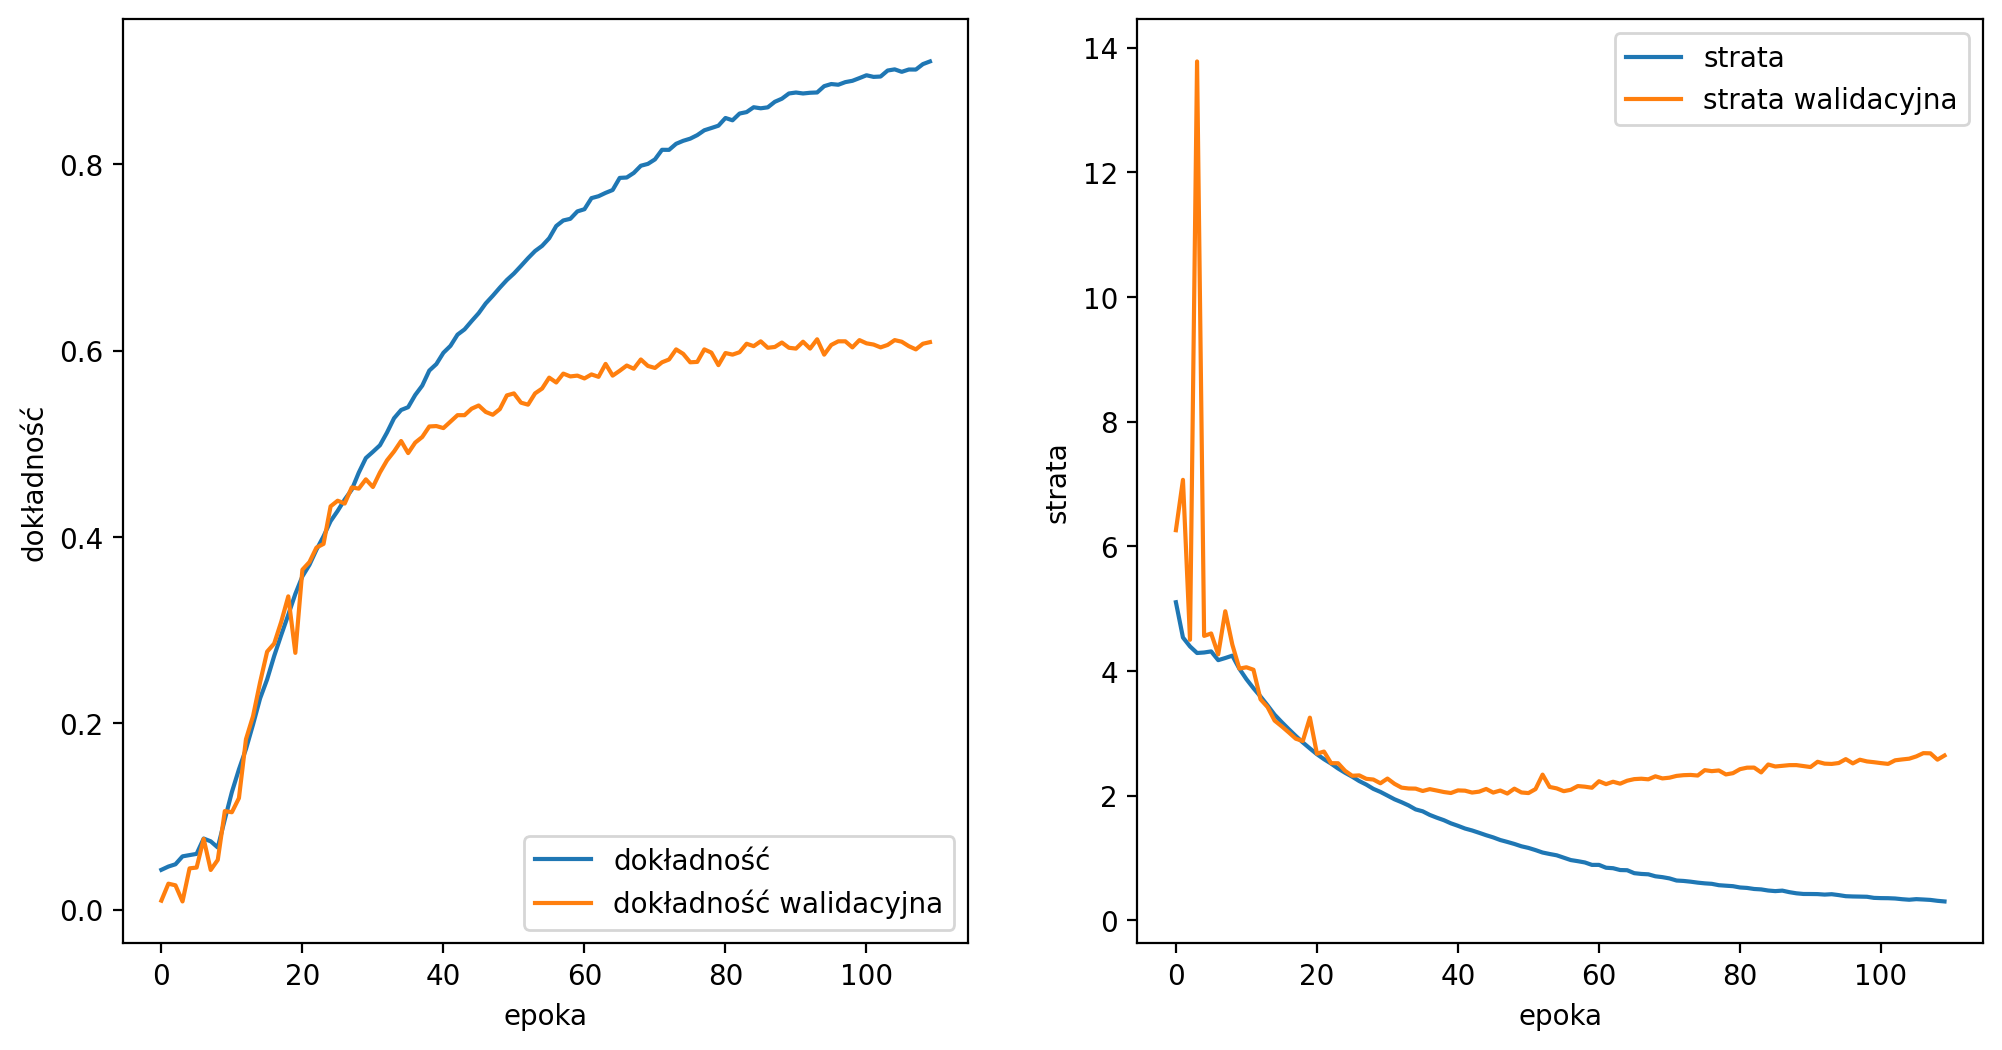

<Figure size 640x480 with 0 Axes>

In [ ]:
import pickle
import matplotlib.pyplot as plt

file_path = 'drive/MyDrive/Praca_inzynierska/history_lstmm.pkl'
with open(file_path, 'rb') as file:
    history = pickle.load(file)

if history is not None:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='dokładność')
    plt.plot(history['val_accuracy'], label='dokładność walidacyjna')
    plt.xlabel('epoka')
    plt.ylabel('dokładność')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='strata')
    plt.plot(history['val_loss'], label='strata walidacyjna')
    plt.xlabel('epoka')
    plt.ylabel('strata')
    plt.legend(loc='upper right')

    plt.show()
    plt.savefig('drive/MyDrive/Praca_inzynierska/_110_LSTMM_acc_loss.png')
else:
    print("ERROR: Nie udało się wczytać historii treningu.")


In [ ]:
model = load_model("drive/MyDrive/Praca_inzynierska/gru.hdf5")
print("DONEE")

DONEE


In [ ]:
def oblicz_pochodna(offsets, pitches): #
    pochodna = [0]
    for i in range(1, len(offsets)):
        delta_offset = offsets[i] - offsets[i - 1]
        delta_pitch = pitches[i] - pitches[i - 1]
        pochodna_wzgledem_czasu = delta_pitch / delta_offset
        pochodna.append(pochodna_wzgledem_czasu)
    return pochodna

In [ ]:
# generowanie nowych nut
#  50 100, 60 62 90 lstm
#  70, 90, 66  72 gru

import random
np.random.seed(50)
number_of_notes = (58 * 6)
start = np.random.randint(0, len(network_input_test) - sequence_length - 1)
#start = 2
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
#pattern = network_input_test[start] # dane testowe
pattern = (np.random.uniform(0, (n_vocab - 1), seq)) / n_vocab # SZUM BIALY
#tr = network_input_test[start]
tr = pattern
train = []
prediction_output = []
for note_index in range(number_of_notes):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1)) # normalizacja
  #  prediction_input = prediction_input / float(n_vocab)
    prediction = model.predict(prediction_input, verbose=0)
    index = np.argmax(prediction)
    # print(pattern)
    result = int_to_note[index]
    prediction_output.append(result)
    index = index / float(n_vocab)
    pattern = np.append(pattern, index)
    pattern = pattern[1:len(pattern)]
    if(note_index < seq ):
       k = (tr[note_index])
       j = n_vocab * k
       w = int_to_note[int(j)]
       train.append(w)
    #cos = int_to_note[tr[note_index]]
    #train = np.append(train, cos)

#print(train)
#print(len(train))
print(start)
print(len(pattern))
print("______________________")
print(train)
print(len(train))
print("______________________")
#print(pattern)
#print(len(pattern))
print("DONE")
print("______________________")
print(prediction_output)
print(len(prediction_output))
print("______________________")


2226
65
______________________
['G#5', '4.6.7.9', '5.8.0', 'E-6', '4.5.8', '5.6', '2.5', '8.11.2.4', '2.3.4', '3.5.9', '10.2', '4.5.8.11', '1.3.6.8', '2.6', '4.5.8.11', '4.9', '4.8.10', '6.9.11', '6.7', '0.2.3.5', '10.0.2.5', '1.7', '6.9.1', '8.9.10.11.0.1', '9.11.2', '8.11.1.3', '5.8', '8.0', '0.4.7', '2.6', 'E-2', '11.1.6', '4.7.11', 'F3', '7', '2.4.7.9', '11.1.4', '9.11.1.4', 'F3', '9.10.1.2.4', '3.5', '2.5.9', '10.1', '1.4', '11.1.4', '2.5.9', 'F2', 'D5', '4.7.10.0', 'F4', '4.5.6.8.10.11', '5.8.0', '2.6', '0.3.6', '4.5.9.10', '11.1.3.6', '2.5.9', '3.4.6.8.10.11', '11.0.1.2.3', '7.9.10', 'E-6', 'G3', 'G#4', 'D3', '9']
65
______________________
DONE
______________________
['B-4', 'B-4', 'B-4', 'A4', 'B-4', 'B-4', 'F4', 'B-4', '6.10.1', 'A4', 'F4', 'A4', 'F4', 'A3', 'B-4', 'F4', 'B-4', 'G4', '6.10', 'A4', '3.6', '6', '2.5', '11.2', '11.2', '4.8.11', '11.3.6', '8.11', '6.11', 'C#4', '11.3.6', '11.3.6', '1.4.8', 'E4', 'E4', '1.4.8', 'F#4', '1.4.8', 'A2', '11.3.6', 'C4', '2.7', 'C4', 'C4

In [ ]:
print(prediction_output)

['2.5', '2.5', 'G3', '2.5', '2.5', 'C#4', '2.5', '2.5', 'B-3', '2.5', '2.5', '2.5', '2.5', '2.5', '11.3.6', '4.8.11', '1.4', 'G3', '1.4', '1.4', '1.4', 'A3', '0.4', '2.5', '0.4', '4.7', '7.0', '2.6', 'A3', '7.0', 'C4', 'C4', '2.5', 'B-3', '2.5', 'G3', '2.6.9', '2.5', 'A3', '2.5', '2.6.9', '2.6', '2.5', '2.5', 'G3', 'F4', '10.2.5', '2.5', 'B-3', 'C4', 'F4', '0.4.7', 'F3', 'F3', 'B-4', 'F4', '5.9.0', '5.9.0', 'B-3', 'F4', 'E5', 'C3', 'E3', 'F#3', 'D5', 'F#3', '0.4.7', 'C4', '0.4.7', 'C4', 'F4', 'F4', 'E4', 'D4', 'D4', 'B-4', 'F#3', 'D5', 'D4', 'G2', 'E4', 'C4', 'G3', '2.7', 'D4', 'G3', 'G4', 'D4', 'F3', 'D4', 'D4', 'F4', 'F4', 'F4', 'D4', 'E4', 'G3', 'D4', 'D4', 'F4', 'G3', 'G3', 'C4', 'D4', 'G3', 'D4', 'G3', 'C4', 'C4', 'A3', 'G3', 'C4', 'C4', 'A4', 'G3', 'C4', 'D4', '0.4.7', 'A4', 'G3', 'G3', 'A4', 'D4', 'B3', 'A4', 'G4', 'C4', 'D4', 'B3', 'B3', 'B3', 'D4', 'G4', 'D4', 'D4', 'G4', 'D4', 'G2', 'G4', 'C4', 'B3', 'G3', 'D4', 'B-4', 'G4', 'D4', 'G4', 'C4', 'F#4', 'B3', 'A4', 'F#4', 'F#4', 

In [ ]:
# tworzenie nut i akordów dla nowych danych
offset = 0  # przesuniecie nut lub akordów (czas)
output_notes = []

for item in prediction_output:
    # szukanie akordów
    if ('.' in item) or item.isdigit():
        notes_in_chord = item.split('.')
      #  print(notes_in_chord)
        notes12 = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.AcousticGuitar()
            notes12.append(new_note)
        new_chord = chord.Chord(notes12)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # nuta
    else:
          #   print(item)
        new_note = note.Note(item)
        new_note.offset = offset
        new_note.storedInstrument = instrument.AcousticGuitar()
        output_notes.append(new_note)

    offset += 1
       # new_note = note.Note(item)
       # new_note.offset = offset
       # new_note.storedInstrument = instrument.AcousticGuitar()
       # output_notes.append(new_note)



print("DONE")
print(output_notes)

DONE
[<music21.note.Note B->, <music21.note.Note B->, <music21.note.Note B->, <music21.note.Note A>, <music21.note.Note B->, <music21.note.Note B->, <music21.note.Note F>, <music21.note.Note B->, <music21.chord.Chord F# B- C#>, <music21.note.Note A>, <music21.note.Note F>, <music21.note.Note A>, <music21.note.Note F>, <music21.note.Note A>, <music21.note.Note B->, <music21.note.Note F>, <music21.note.Note B->, <music21.note.Note G>, <music21.chord.Chord F# B->, <music21.note.Note A>, <music21.chord.Chord E- F#>, <music21.chord.Chord F#>, <music21.chord.Chord D F>, <music21.chord.Chord B D>, <music21.chord.Chord B D>, <music21.chord.Chord E G# B>, <music21.chord.Chord B E- F#>, <music21.chord.Chord G# B>, <music21.chord.Chord F# B>, <music21.note.Note C#>, <music21.chord.Chord B E- F#>, <music21.chord.Chord B E- F#>, <music21.chord.Chord C# E G#>, <music21.note.Note E>, <music21.note.Note E>, <music21.chord.Chord C# E G#>, <music21.note.Note F#>, <music21.chord.Chord C# E G#>, <music21.

In [ ]:
# nowe dane


offsets = []
pitches = []

for item in output_notes:
    if isinstance(item, note.Note):
        offsets.append(item.offset)
        pitches.append(item.pitch.midi)
    elif isinstance(item, chord.Chord):
        chord_pitches = [note_in_chord.pitch.midi for note_in_chord in item.notes]
        avg_pitch = sum(chord_pitches) / len(chord_pitches) # dla akordów liczona jest średnia arytmetyczna
        offsets.append(item.offset)
        pitches.append(avg_pitch)



pochodna = oblicz_pochodna(offsets, pitches)


plt.figure(figsize=(15, 8))

plt.plot(offsets, pitches, marker='o', linestyle='-', color='b', label='Krzywa tonalna')

plt.plot(offsets, np.abs(pochodna), linestyle='-', color='r', label='Moduł pochodnej')

plt.axhline(y=16, linestyle='--', color='g', label='Y=17')
plt.axhline(y=50, linestyle='--', color='#800080', label='Y=50')
plt.axhline(y=73, linestyle='--', color='#800080', label='Y=73')
plt.axvline(x=101, linestyle='--', color='#000000', label='X=101')
plt.title('Krzywa tonalna i moduł jej pochodnej')
plt.xlabel('Czas')
plt.ylabel('Wysokość tonu')
plt.ylim(0, 80)
#plt.xlim(140, 180)

# Legenda
plt.legend()

# Zapisz wykres
plt.savefig('drive/MyDrive/Praca_inzynierska/wykresy_dla_wygenerowanych/GRU_wykres_tonalny_dla_wyegenrowanych_5.png')

# Wyświetl wykres
plt.show()
print(len(pitches))
print(pitches)
print(len(offsets))
print(offsets)
print(len(pochodna))
print(pochodna)

file_out = f'drive/MyDrive/Praca_inzynierska/wykresy_dla_wygenerowanych/GRU_dla_wyegenrowanych_5_przyciete_do_dobrego_utworu.mid'

output_notes = output_notes[101:]

midi_stream = stream.Stream()

guitar = instrument.Guitar()
midi_stream.append(guitar)

for item in output_notes:
    if isinstance(item, note.Note) or isinstance(item, chord.Chord):
        # Ustaw instrument dla każdej nuty i akordu
        item.storedInstrument = guitar
      #  item.offset = offset
        midi_stream.append(item)
        #offset += 0.5

#file_out = f'MODEL{num_of_neurons}neurons_{epochs}epochs_{batch_size}batchsize_{seq}seq_len_{num_of_layers}_num_of_layers.mid'
midi_stream.write('midi', fp=file_out)
print("DONE")


In [ ]:
# DLA DANYCH TRENINGOWYCH

offset = 0  # przesuniecie nut lub akordów (czas)
output_notes1 = []

for item in train:
    # szukanie akordów
    if ('.' in item) or item.isdigit():
        notes_in_chord = item.split('.')
      #  print(notes_in_chord)
        notes12 = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.AcousticGuitar()
            notes12.append(new_note)
        new_chord = chord.Chord(notes12)
        new_chord.offset = offset
        output_notes1.append(new_chord)
    # nuta
    else:
          #   print(item)
        new_note = note.Note(item)
        new_note.offset = offset
        new_note.storedInstrument = instrument.AcousticGuitar()
        output_notes1.append(new_note)

    offset += 1


offsets1 = []
pitches1 = []

for item in output_notes1:
    if isinstance(item, note.Note):
        offsets1.append(item.offset)
        pitches1.append(item.pitch.midi)
    elif isinstance(item, chord.Chord):
        chord_pitches = [note_in_chord.pitch.midi for note_in_chord in item.notes]
        avg_pitch = sum(chord_pitches) / len(chord_pitches) # dla akordów liczona jest średnia arytmetyczna
        offsets1.append(item.offset)
        pitches1.append(avg_pitch)

pochodna = oblicz_pochodna(offsets1, pitches1)

# Utwórz nowy wykres na tym samym obiekcie Figure
plt.figure(figsize=(15, 8))

# Wykres krzywej tonalnej
plt.plot(offsets1, pitches1, marker='o', linestyle='-', color='b', label='Krzywa tonalna')

# Wykres modułu pochodnej
plt.plot(offsets1, np.abs(pochodna), linestyle='-', color='r', label='Moduł pochodnej')
plt.axhline(y=16, linestyle='--', color='g', label='Y=16')
plt.axhline(y=50, linestyle='--', color='#800080', label='Y=50')
plt.axhline(y=74, linestyle='--', color='#800080', label='Y=74')
# Ustawienia wykresu
plt.title('Krzywa tonalna i moduł jej pochodnej')
plt.xlabel('Czas')
plt.ylabel('Wysokość tonu')
plt.ylim(0, 90)

plt.legend()

# Zapisz wykres
plt.savefig('drive/MyDrive/Praca_inzynierska/wykresy_dla_oryginalnych_utworow/GRwykres_tonalny_i_modul_pochodnej_dla_oryginalnego_otworu_4.png')

file_out = f'drive/MyDrive/Praca_inzynierska/wykresy_dla_oryginalnych_utworow/GRwykres_tonalny_i_modul_pochodnej_dla_oryginalnego_otworu_4.mid'

midi_stream = stream.Stream()

guitar = instrument.Guitar()
midi_stream.append(guitar)

for item in output_notes1:
    if isinstance(item, note.Note) or isinstance(item, chord.Chord):
        # Ustaw instrument dla każdej nuty i akordu
        item.storedInstrument = guitar
      #  item.offset = offset
        midi_stream.append(item)
        #offset += 0.5

#file_out = f'trening_MODEL{num_of_neurons}neurons_{epochs}epochs_{batch_size}batchsize_{seq}seq_len_{num_of_layers}_num_of_layers.mid'
midi_stream.write('midi', fp=file_out)
print("DONE")


In [ ]:
# tworzenie pliku midi
#offset = 0
file_out = f'drive/MyDrive/Praca_inzynierska/szum_bialy_nowe_dane_wykres_tonalny_gru5.mid'

midi_stream = stream.Stream()

guitar = instrument.Guitar()
midi_stream.append(guitar)

for item in output_notes:
    if isinstance(item, note.Note) or isinstance(item, chord.Chord):
        # Ustaw instrument dla każdej nuty i akordu
        item.storedInstrument = guitar
      #  item.offset = offset
        midi_stream.append(item)
        #offset += 0.5

#file_out = f'MODEL{num_of_neurons}neurons_{epochs}epochs_{batch_size}batchsize_{seq}seq_len_{num_of_layers}_num_of_layers.mid'
midi_stream.write('midi', fp=file_out)
print("DONE")



DONE


In [ ]:
mf = converter.parse(file_out)
mf.show('midi')

In [ ]:
print(prediction_output)

['A4', 'C4', 'C4', 'E4', 'E4', 'G4', 'G4', '9.11.2', '9.11.2', '9.11.2', '9.11.2', '11.4', '11.4', 'D4', 'D4', 'C4', 'C4', 'E4', 'E4', 'E4', 'E4', 'G4', 'G4', 'G4', 'G4', 'A4', 'A4', 'C4', 'C4', 'E4', 'E4', 'G4', 'G4', '9.0.2.5', '9.0.2.5', '0.2.5.7', '0.2.5.7', '9.0.2.5', '9.0.2.5', '0.2.5.7', '0.2.5.7', '0.4.7', '0.4.7', '0.2.7', '0.2.7', '5.9.0', '5.9.0', 'E4', 'E4', 'E4', 'E4', 'E4', 'E4', '0.4.7', '0.4.7', '0.4.7', '0.4.7', '2.7']


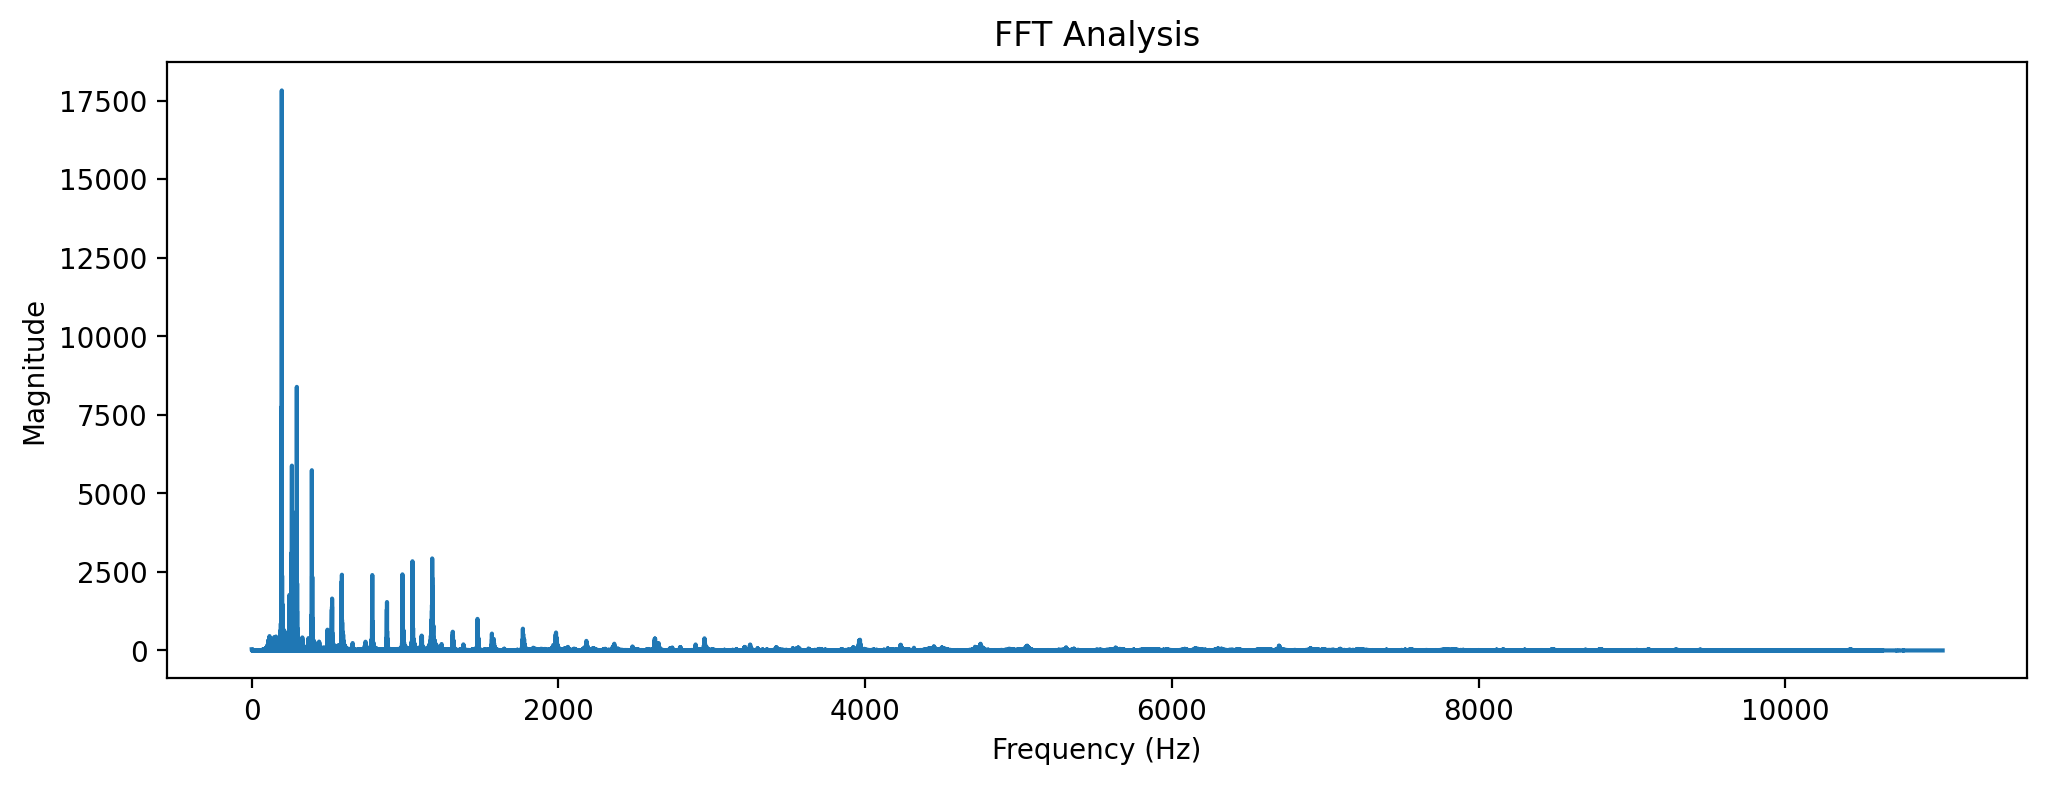

In [ ]:
import librosa
import librosa.display

file_path = 'drive/MyDrive/Praca_inzynierska/wykresy_dla_wygenerowanych/GRU_dla_wyegenrowanych_4_przyciete_do_dobrego_utworu.wav'
output_image_path = 'drive/MyDrive/Praca_inzynierska/wykresy_dla_wygenerowanych/GRU_dla_wyegenrowanych_4_przyciete_do_dobrego_utworuFFT.png'
y, sr = librosa.load(file_path)

fft_result = np.fft.fft(y)
magnitude = np.abs(fft_result)
frequency = np.fft.fftfreq(len(magnitude), 1/sr)


plt.figure(figsize=(12, 4))
plt.plot(frequency[:len(frequency)//2], magnitude[:len(magnitude)//2])
plt.title('FFT Analysis')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')


plt.savefig(output_image_path)
plt.show()

